# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## План работы над проектом

1) Провести исследовательский анализ набора фотографий.

2) Подготовить данные к обучению.

3) Обучить нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

 * Выгрузим данные и поделим их на выборки
 * Построим график распределения возраста
 * Выведем на экран 10-15 фотографий и посмотрим, как устроен датасете

In [41]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
 
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [42]:
# Задаем путь к данным
data_path = '/datasets/faces/'
img_path = data_path + 'final_files/'

In [43]:
# Выгружаем таблицу с метками
labels = pd.read_csv(data_path + 'labels.csv')
labels.shape

(7591, 2)

In [44]:
# Cоздаем генератор данных
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
datagen

In [45]:
# Cоздаем генератор для тренировачных данных
train_generator = datagen.flow_from_dataframe(dataframe=labels,
                                              directory=img_path,
                                              x_col='file_name',
                                              y_col='real_age',
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='raw',
                                              subset='training')

Found 5694 validated image filenames.


In [46]:
# Создаем генератор для тестовых данных
test_generator = datagen.flow_from_dataframe(dataframe=labels,
                                            directory=img_path,
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='raw',
                                            subset='validation')

Found 1897 validated image filenames.


In [47]:
# Выводим размер выборок
print('Размер обучающей выборки:', len(train_generator))
print('Размер валидационной выборки:', len(test_generator))

Размер обучающей выборки: 178
Размер валидационной выборки: 60


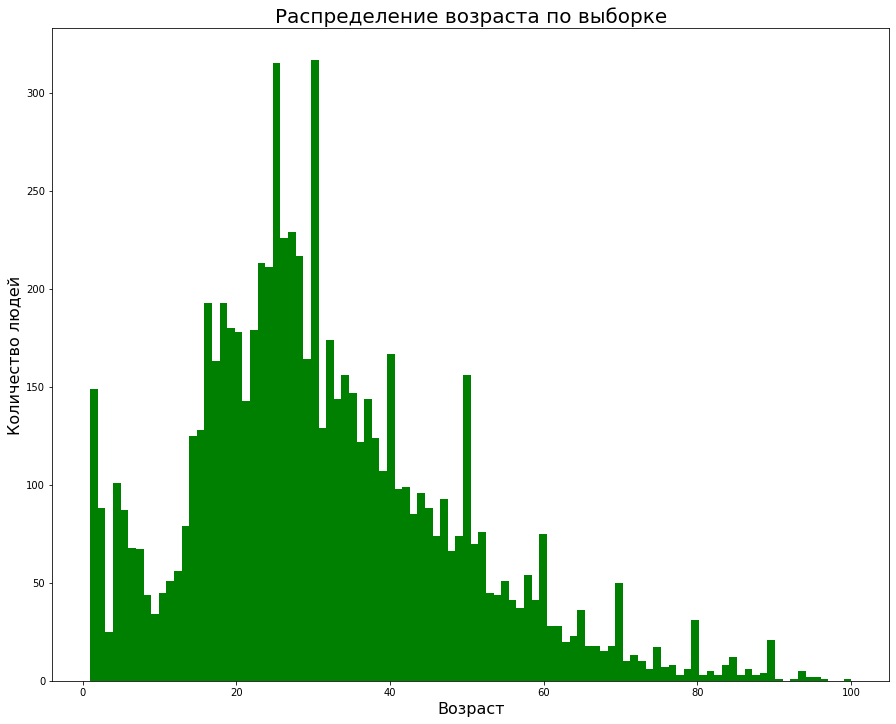

In [48]:
# Построим график распределения возраста в выборке
plt.figure(figsize=(15, 12))
plt.hist(labels['real_age'], bins=100, color='Green')
plt.title('Распределение возраста по выборке', fontsize=20)
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Количество людей', fontsize=16)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()

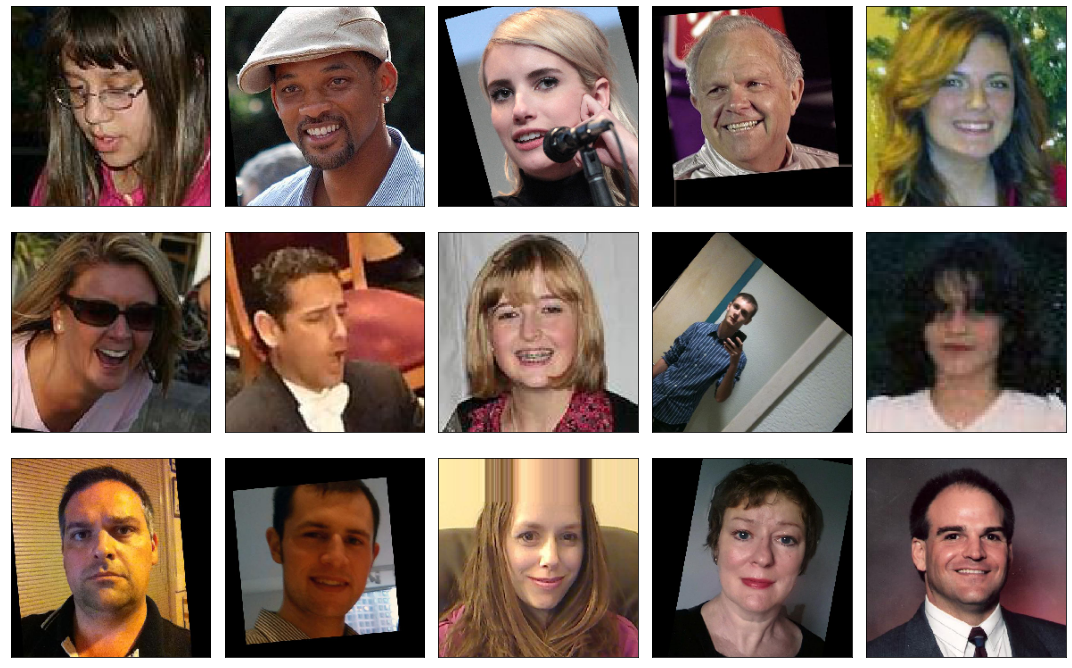

In [40]:
# Выведем 15 фотографий
features, target = next(train_generator)

fig = plt.figure(figsize=(15,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** 
* Данные выгружены, поделены на выборки.
* Размеры полученных выборок (тренировачная: 178, валидационная: 60)
* Построен график, из которого можно сделать вывод, что больше всего людей находятся в диапозоне возраста от 20 до 30 лет.
* Выгружены 15 фотографий, исходные фотографии изображены горизонтально, имеют цветовую политру, но при этом у них разный размер из-за ширины и высоты.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_generator = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_generator

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_generator = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_generator


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-04-26 13:34:12.741733: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-26 13:34:13.034209: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 196.3117 - mae: 10.1805 - val_loss: 468.9092 - val_mae: 16.4792
Epoch 2/10
356/356 - 42s - loss: 84.1390 - mae: 6.9020 - val_loss: 124.8617 - val_mae: 8.4709
Epoch 3/10
356/356 - 42s - loss: 56.5758 - mae: 5.7545 - val_loss: 88.4822 - val_mae: 6.9518
Epoch 4/10
356/356 - 44s - loss: 42.1478 - mae: 4.9682 - val_loss: 73.3431 - val_mae: 6.5375
Epoch 5/10
356/356 - 44s - loss: 31.7834 - mae: 4.3163 - val_loss: 73.0565 - val_mae: 6.4598
Epoch 6/10
356/356 - 47s - loss: 24.8562 - mae: 3.8490 - val_loss: 73.9362 - val_mae: 6.4169
Epoch 7/10
356/356 - 46s - loss: 18.7036 - mae: 3.3331 - val_loss: 69.9660 - val_mae: 6.1764
Epoch 8/10
356/356 - 47s - loss: 16.2380 - mae: 3.0538 - val_loss: 67.3840 - val_mae: 6.2560
Epoch 9/10
356/356 - 47s - loss: 14.3590 - mae: 2.8786 - val_loss: 75.4937 - val_mae: 6.7568
Epoch 10/10
356/356 - 47s - loss: 13.4582 - mae: 2.7953 - val_loss: 64.0017 - val_mae: 5.8973
WARNING:tensorflow:sample_weight modes were coerced from

119/119 - 11s - loss: 64.0017 - mae: 5.8973
Test MAE: 5.8973

```

## Анализ обученной модели

Модель построена на ResNet50, для обучения модели использовалось 10 эпох, с помощью которых удалось достичь результат и уменьшить MAE с 10,1 до 2,8 на тренировачной выборке, на тестевой выборке модель показала результат MAE равный 5,89, что говорит о хорошем показателе предсказаний, то есть MAE не больше 8, .

## Чек-лист

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Исследовательский анализ данных выполнен
- [X]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [X]  MAE модели не больше 8
- [X]  Код обучения модели скопирован в финальную тетрадь
- [X]  Результат вывода модели на экран перенесён в финальную тетрадь
- [X]  По итогам обучения модели сделаны выводы